This notebook contains code to obtain BERT classification results.<br />
The model was trained on Colab, so inline results of the run are omitted and shown as figures.<br />
Use ktrain (https://github.com/amaiya/ktrain) - a lightweight Keras library - to train the model.

In [2]:
import ktrain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

from ktrain import text
from sklearn.model_selection import train_test_split
from IPython.display import Image

In [3]:
# Define emotion classes.
emotions = ['joy', 'sadness', 'fear', 'anger', 'neutral']

In [4]:
# Get training data.
data_train = pd.read_csv('../../data/training_data/data_train_5_classes.csv')
data_test = pd.read_csv('../../data/training_data/data_test_5_classes.csv')

In [4]:
X_train = data_train.Text.tolist()
X_test = data_test.Text.tolist()

y_train = data_train.Emotion.tolist()
y_test = data_test.Emotion.tolist()

data = data_train.append(data_test, ignore_index=True)

In [5]:
encoding = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'neutral': 4
}

# Encode output.
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

In [7]:
# Preprocess data.
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=emotions,
                                                                       preprocess_mode='bert',
                                                                       maxlen=500, 
                                                                       max_features=50000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [8]:
# Initialise BERT model.
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 500
done.


In [9]:
# Prepare model for training.
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=8)

In [ ]:
# Find the best learning rate.
# Note: running this cell takes a really long time.
learner.lr_find()
learner.lr_plot()

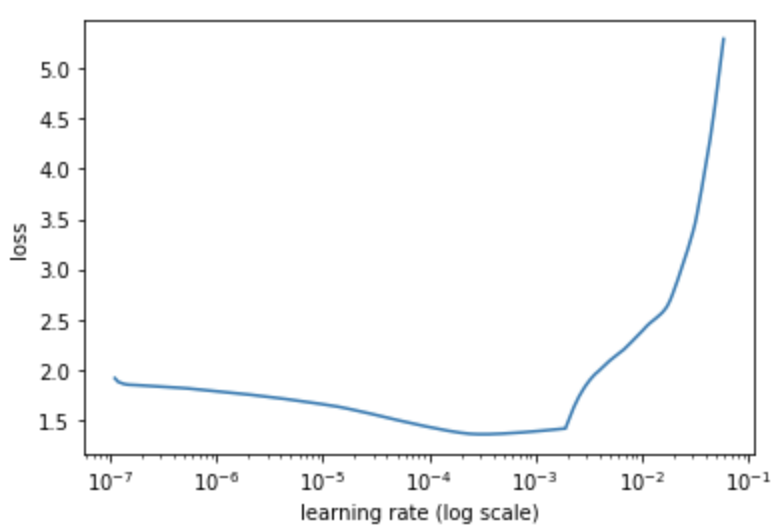

In [16]:
# Display the results of learning rate search.
# The plot was generated by running the above cell in the process of fine-tuning the model.
Image(filename='../../data/BERT_plots/bert_5_lr.png', width = 400, height = 100) 

According to https://arxiv.org/pdf/1803.09820.pdf it is best to select learning rate at which the loss drops the fastest. In this case, the model will be fitted with learning rate of 1e-4.

In [ ]:
# Fit the model with automatic adjustment of learning rate.
# Note: running this cell takes a really long time.
learner.autofit(1e-4)

In [ ]:
# Display validation results.
# Note: running this cell takes a really long time.
out = learner.validate(val_data=(x_test, y_test), class_names=emotions)

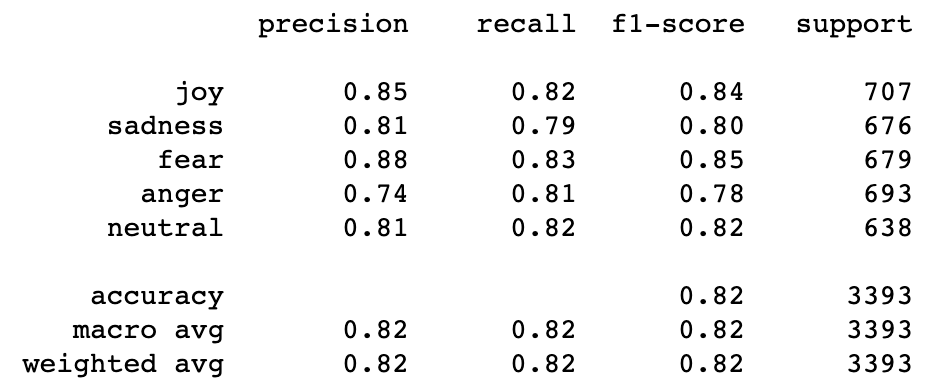

In [17]:
# Display validation results.
# The table was generated by running the above cell in the process of fine-tuning the model.
Image(filename='../../data/BERT_plots/bert_5_validation.png', width = 400, height = 100) 

In [ ]:
# Display confusion matrix.
# Real labels on the left, predicted on the bottom.
df_cm = pd.DataFrame(out, index = [i for i in emotions],
                  columns = [i for i in emotions])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

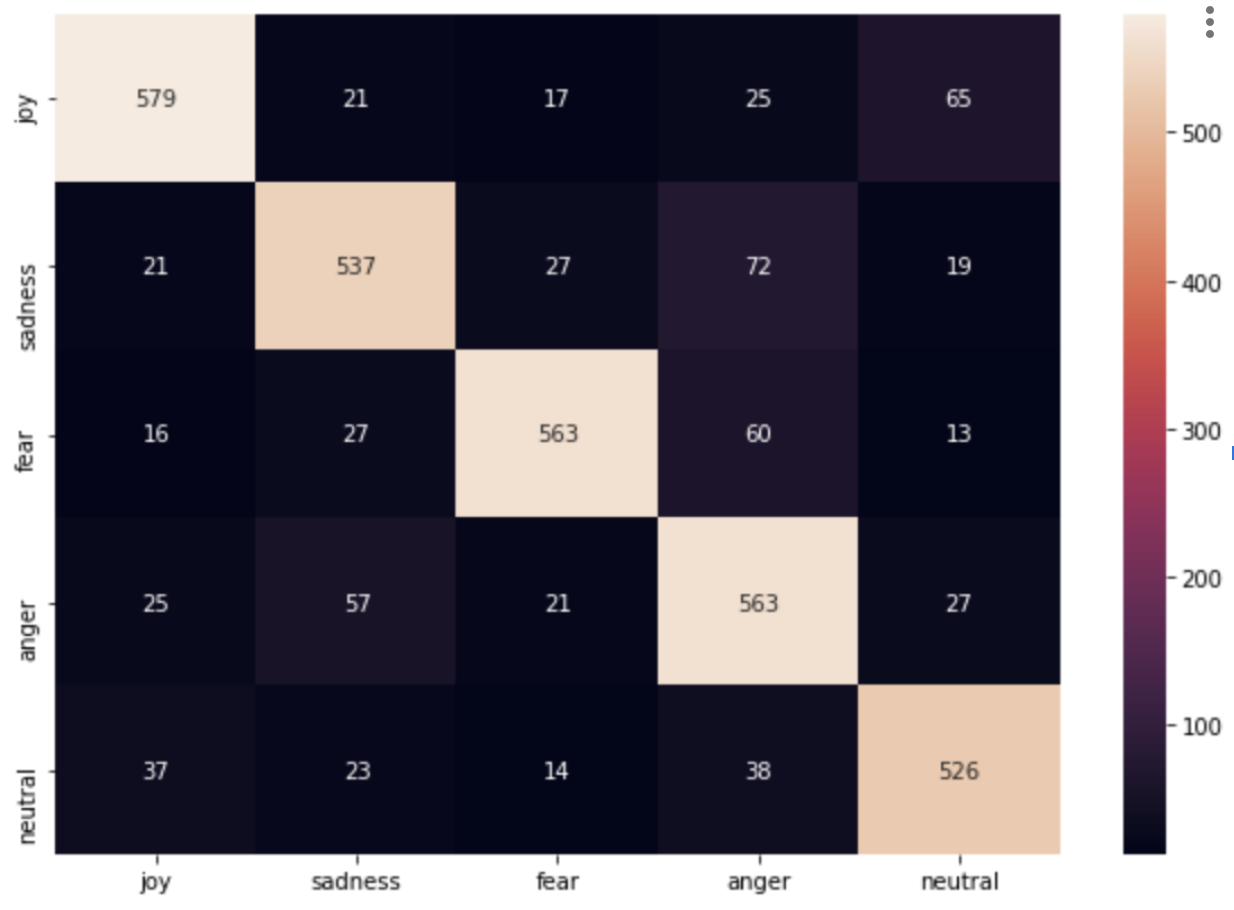

In [3]:
# The table was generated by running the above cell in the process of fine-tuning the model.
Image(filename='../../data/BERT_plots/bert_5_confusion.png', width = 500) 

In [ ]:
# Obtain the predictor.
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

In [ ]:
# Save the predictor for future use.
predictor.save('../../trained_models/bert_model_final_5')

In [30]:
# Get Amazon data and prepare the dataframe.
amazon = pd.read_csv('../../data/preprocessed/amazon.csv')

In [31]:
amazon['PREDICTION'] = 0
amazon['joy'] = 0
amazon['sadness'] = 0
amazon['fear'] = 0
amazon['anger'] = 0
amazon['neutral'] = 0

In [34]:
# Make predictions on Amazon data and store results and probabilities.
for i in range(len(amazon['REVIEW_TEXT'])):
    if i%1000 == 0:
        print('processing', i, ' of', len(amazon))
    out = predictor.predict(amazon['REVIEW_TEXT'][i], return_proba=True)
    amazon.iloc[i, amazon.columns.get_loc('joy')] = out[0]
    amazon.iloc[i, amazon.columns.get_loc('sadness')] = out[1]
    amazon.iloc[i, amazon.columns.get_loc('fear')] = out[2]
    amazon.iloc[i, amazon.columns.get_loc('anger')] = out[3]
    amazon.iloc[i, amazon.columns.get_loc('neutral')] = out[4]
    amazon.iloc[i, amazon.columns.get_loc('PREDICTION')] = predictor.get_classes()[np.argmax(out)]

processing 0  of 20974
processing 1000  of 20974
processing 2000  of 20974
processing 3000  of 20974
processing 4000  of 20974
processing 5000  of 20974
processing 6000  of 20974
processing 7000  of 20974
processing 8000  of 20974
processing 9000  of 20974
processing 10000  of 20974
processing 11000  of 20974
processing 12000  of 20974
processing 13000  of 20974
processing 14000  of 20974
processing 15000  of 20974
processing 16000  of 20974
processing 17000  of 20974
processing 18000  of 20974
processing 19000  of 20974
processing 20000  of 20974


In [35]:
amazon

,REVIEW_TEXT,VERACITY,PREDICTION,joy,sadness,fear,anger,neutral
0,"When least you think so, this product will sav...",Fake,joy,0.607511,0.000613,0.005562,0.028179,0.358134
1,Lithium batteries are something new introduced...,Fake,fear,0.002090,0.000303,0.991995,0.000519,0.005092
2,I purchased this swing for my baby. She is 6 m...,Fake,neutral,0.230047,0.113521,0.005186,0.007936,0.643311
3,I was looking for an inexpensive desk calcolat...,Fake,fear,0.005873,0.005968,0.802328,0.023309,0.162521
4,I only use it twice a week and the results are...,Fake,anger,0.000760,0.003227,0.000523,0.923575,0.071914
...,...,...,...,...,...,...,...,...
20969,"I bought these for work. I have high arches, ...",Real,neutral,0.009351,0.000091,0.000188,0.001287,0.989083
20970,Crocs are one of only two brands of shoes that...,Real,fear,0.005886,0.002728,0.943552,0.043933,0.003901
20971,I love moccasins This fit like it was custom ...,Real,neutral,0.340928,0.000442,0.020493,0.003363,0.634773
20972,I wish these were a little more durable. I got...,Real,fear,0.053780,0.003896,0.709929,0.011274,0.221120


In [39]:
amazon.to_csv('../../data/results/amazon_bert5.csv', index = False)